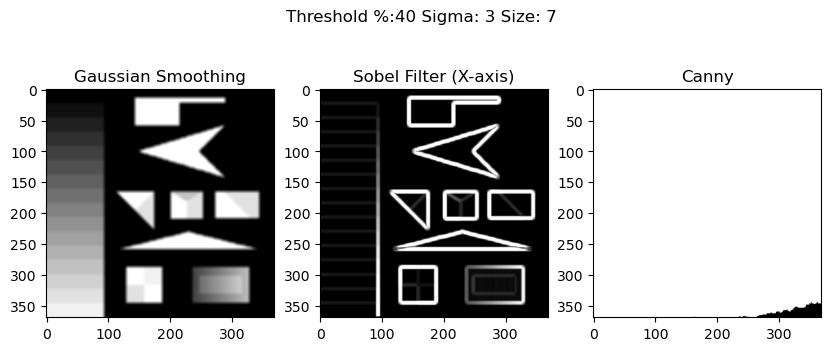

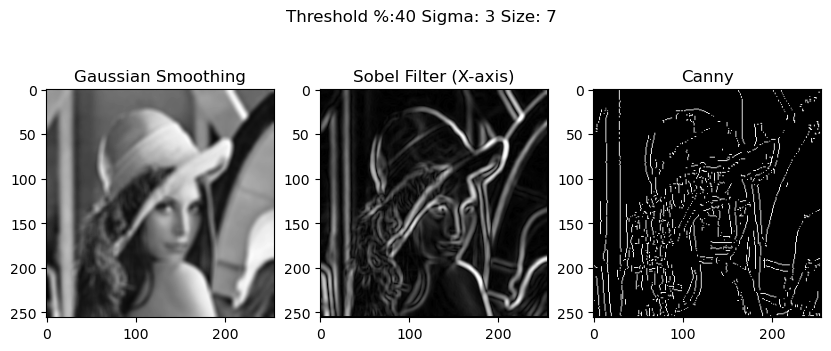

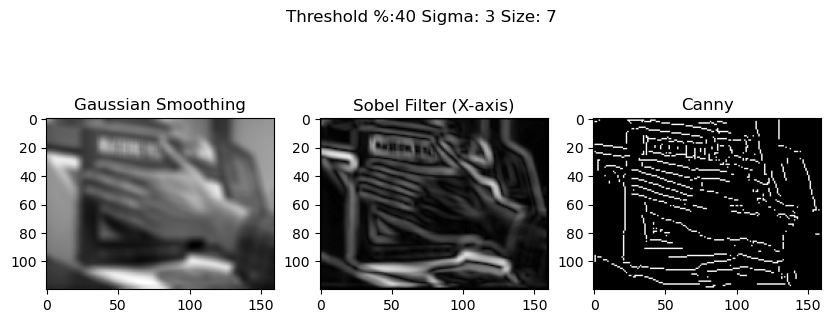

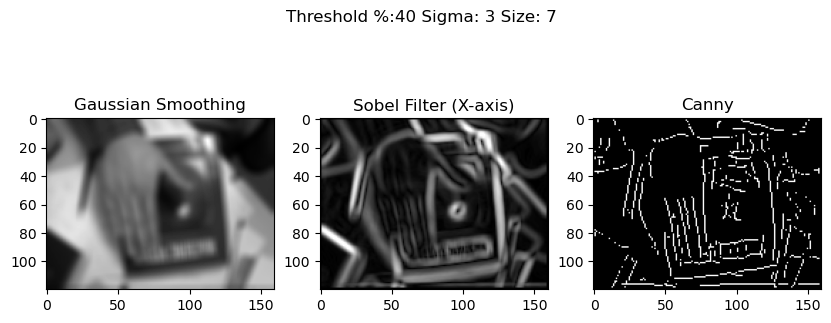

In [264]:
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from scipy import ndimage

def link_edges(strong_edges, weak_edges, max_depth=2000):
    # Initialize the visited array and the list of edges
    visited = np.zeros_like(strong_edges)
    edges = []
    
    # Recursively link the strong edges
    for i in range(strong_edges.shape[0]):
        for j in range(strong_edges.shape[1]):
            if strong_edges[i, j] and not visited[i, j]:
                # Start a new edge
                edge = []
                visit_edge(i, j, visited, strong_edges, weak_edges, edge, depth=0, max_depth=max_depth)
                edges.append(edge)
                
    # Fill the gaps between strong edges using the weak edges
    for edge in edges:
        for pixel in edge:
            if weak_edges[pixel[0], pixel[1]]:
                strong_edges[pixel[0], pixel[1]] = True
    
    return strong_edges
    
def visit_edge(i, j, visited, strong_edges, weak_edges, edge, depth, max_depth):
    # Check if the maximum recursion depth has been reached
    if depth >= max_depth:
        return
    
    # Mark the current pixel as visited
    visited[i, j] = 1
    
    # Add the current pixel to the current edge
    edge.append((i, j))
    
    # Visit the neighbors of the current pixel
    for ii in range(i-1, i+2):
        for jj in range(j-1, j+2):
            if ii >= 0 and ii < visited.shape[0] and jj >= 0 and jj < visited.shape[1]:
                if (strong_edges[ii, jj] and not visited[ii, jj]) or (weak_edges[ii, jj] and not visited[ii, jj]):
                    visit_edge(ii, jj, visited, strong_edges, weak_edges, edge, depth+1, max_depth)
                    
files = ["test1.bmp","lena.bmp","pointer1.bmp","joy1.bmp"]
for file in files:
    img = Image.open(file).convert('L')

    size = 7
    sigma = 3
    tt=40

    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x = i - (size // 2)
            y = j - (size // 2)
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    kernel /= np.sum(kernel)
    img=np.array(img)
    smooth_img = ndimage.convolve(img, kernel)
    smooth_img = np.array(smooth_img)
    Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
    [rows, columns] = np.shape(smooth_img)  
    sobel_filtered_image_mag = np.zeros(shape=(rows, columns))  
    sobel_filtered_image_dir = np.zeros(shape=(rows, columns))  


    for i in range(rows - 2):
        for j in range(columns - 2):
            gx = np.sum(np.multiply(Gx, smooth_img[i:i + 3, j:j + 3]))  # x direction
            gy = np.sum(np.multiply(Gy, smooth_img[i:i + 3, j:j + 3]))  # y direction
            sobel_filtered_image_mag[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)  # calculate the "hypotenuse"
            sobel_filtered_image_dir[i + 1, j + 1] = np.degrees(np.arctan2(np.array(gy), np.array(gx)))  # calculate the "hypotenuse"


    sobel_filtered_image_dir[sobel_filtered_image_dir < 0] += 180

    hist, bins = np.histogram(sobel_filtered_image_mag.flatten(), bins=256, range=(0, 256))


    cdf = hist.cumsum()


    cdf_normalized = cdf / cdf.max()


    threshold = np.interp(1 - tt / 100, cdf_normalized, bins[:-1])
    min_tres = threshold/2


    angle_quantized = np.zeros_like(sobel_filtered_image_dir, dtype=np.uint8)
    angle_quantized[np.logical_or(sobel_filtered_image_dir < 22.5, sobel_filtered_image_dir >= 157.5)] = 0
    angle_quantized[np.logical_and(sobel_filtered_image_dir >= 22.5, sobel_filtered_image_dir < 67.5)] = 45
    angle_quantized[np.logical_and(sobel_filtered_image_dir >= 67.5, sobel_filtered_image_dir < 112.5)] = 90
    angle_quantized[np.logical_and(sobel_filtered_image_dir >= 112.5, sobel_filtered_image_dir < 157.5)] = 135


    mag_suppressed = np.zeros_like(sobel_filtered_image_mag)
    for i in range(1, sobel_filtered_image_mag.shape[0] - 1):
        for j in range(1, sobel_filtered_image_mag.shape[1] - 1):
            if angle_quantized[i, j] == 0:
                if sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i, j-1] and sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i, j+1]:
                    mag_suppressed[i, j] = sobel_filtered_image_mag[i, j]
            elif angle_quantized[i, j] == 45:
                if sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i-1, j+1] and sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i+1, j-1]:
                    mag_suppressed[i, j] = sobel_filtered_image_mag[i, j]
            elif angle_quantized[i, j] == 90:
                if sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i-1, j] and sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i+1, j]:
                    mag_suppressed[i, j] = sobel_filtered_image_mag[i, j]
            elif angle_quantized[i, j] == 135:
                if sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i-1, j-1] and sobel_filtered_image_mag[i, j] > sobel_filtered_image_mag[i+1, j+1]:
                    mag_suppressed[i, j] = sobel_filtered_image_mag[i, j]




    strong_edges = mag_suppressed > threshold

    weak_edges = np.logical_and(mag_suppressed >= min_tres, mag_suppressed <= threshold)



    
    final =link_edges(strong_edges, weak_edges)
    fname="./result/"+file+str(tt)+"thres_"+str(sigma)+"sig_"+str(size)+"siz.png"
    # Display the original image, the smoothed image, and the Sobel filtered image
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    title = "Threshold %:"+str(tt)+" Sigma: "+str(sigma)+" Size: "+str(size)
    fig.suptitle(title)

    axs[0].imshow(Image.fromarray(smooth_img), cmap='gray')
    axs[0].set_title('Gaussian Smoothing')

    axs[1].imshow(Image.fromarray(sobel_filtered_image_mag), cmap='gray')
    axs[1].set_title('Sobel Filter (X-axis)')

    axs[2].imshow(Image.fromarray(final), cmap='gray')

    axs[2].set_title('Canny')

    plt.show()